In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import simps
from scipy.integrate import quad
from scipy import interpolate
from pylab import *

In [2]:
#Computation of matter power spectrum using the approximation of Eisenstein and Hu, 1998

c = 299792458
ns = 0.9681
h = 0.6790
deltah_squared = 1.868e-9
Omega_lambda = 0.6935
Omega_b = 0.022270/h**2
T_CMB = 2.72548

Omega0 = 1 - Omega_lambda
theta27 = T_CMB/2.7
c_over_H0 = c/(100*1000*h)
alpha_gamma = 1 - 0.328*np.log(431*Omega0*h**2)*Omega_b/Omega0 + 0.38*np.log(22.3*Omega0*h**2)*(Omega_b/Omega0)**2 
s = 44.5*np.log(9.83/(Omega0*h**2))/np.sqrt(1+10*(Omega_b*h**2)**0.75)

#Definition of the transfer function 
def Transfer(k):
    Gamma_eff = Omega0*h*(alpha_gamma + (1-alpha_gamma)/(1+(0.43*k*s)**4))
    q = (k*theta27)/(h*Gamma_eff)
    L0 = np.log(2*np.e + 1.8*q)
    C0 = 14.2 + 731/(1+62.5*q)
    return L0/(L0+C0*q**2)

#Definition of the matter power spectrum without wiggles
def Phs(k):
    Phs = 2*np.pi**2/k**3*deltah_squared*(c_over_H0*k)**(3+ns)*Transfer(k)**2
    return Phs



In [3]:
#Parameters to be modified 

#Primordial non-Gaussianity parameters
gnl =-12.3*10**4
fnl =-1.0
#these are for the labeling of the files
gnl1=12
fnl1=1

#redshift
z=1.0

#Hubble parameter redshift dependant
Hub = (10**8*((1.0 - Omega_lambda)*(1.+z) + (Omega_lambda/(1.+z)**2))**2)**(1./4.)/(2.99792458*10**5)

#Input linear power spectrum from CAMB or CLASS
tabla = np.loadtxt("linear-pk-z1.dat")
ktabla = tabla[:,0]
ptabla = tabla[:,1]
tck=interpolate.splrep(ktabla,ptabla,s=0)

# Adjusting the limits between numerical and analytical
qmin = ktabla[0]
qmax = ktabla[-1]
power_ini = ptabla[0]
power_end = ptabla[-1]
power_rate_ini = ptabla[0]/Phs(ktabla[0])
power_rate_end = ptabla[-1]/Phs(ktabla[-1])


#Definition of linear power spectrum 
def linearpower(q):
    if q<0:
        power = 0.
    elif q < 10**(-5) or q > 10**(4):
        power = 0
    elif q < qmin:
        power = power_rate_ini*Phs(q)
    elif q> qmax:
        power = power_rate_end*Phs(q)
    else:
        power = interpolate.splev(q,tck,der=0)
    return power




In [4]:
#Calculation of the P_R^(2,2) term

def xargument_rel(x,q,k):
    r = q/k
    den = 1. + r**2 - 2.*r*x
    factorx = (6*fnl - 10 + 25*r*(x-r))**2/den**2
    xargument = linearpower(k*np.sqrt(den))*factorx
    return xargument

def p22_argument_rel(q,k):
    r = q/k
    x_bis_min = -1.
    x_bis_max = min(1.,1./(2.*r))
    xintegral = quad(xargument_rel,x_bis_min,x_bis_max,args=(q,k))[0]
    return xintegral
    
def p22_rel(k):
    aux0 = p22_argument_rel(ktabla,k)
    p22_arg = aux0*ptabla/ktabla**2
    p22_integral = simps(p22_arg,ktabla)
    p22 = Hub**4/(16.*np.pi**2)*p22_integral    
    return p22


#Calculation of the P_R^(1,3) term

def p13_relativistic_argument(q, k):   
    r = q/k
    factor = 1./(k*q)**2 * (-gnl + 5./9*fnl + 25./54) - 1./6. * (1 + 2*r**2) / q**4 * (-gnl + 10./3*fnl - 50./27)
    return factor


def p13_relativistic(k):
    aux = p13_relativistic_argument(ktabla, k)
    p13_arg = aux * ptabla * ktabla**2
    second_integral = simps(p13_arg,ktabla)
    p13r = 81/(2.*np.pi)**2*linearpower(k) * second_integral*Hub**4
    return p13r



In [5]:
p22_argument_rel = np.vectorize(p22_argument_rel)

p22r_tabla =list(map(p22_rel,ktabla))


#Saving P_R^(2,2) in a .dat file
np.savetxt("results/p22r-fnl-"+str(fnl1)+".dat",np.transpose([ktabla,p22r_tabla]))


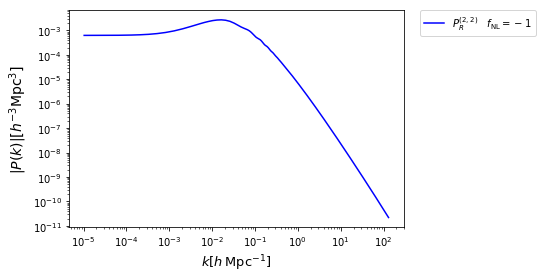

In [6]:
#Plot of P_R^(2,2) term
k22r,pk22r=np.loadtxt('results/p22r-fnl-1.dat',unpack=True)

fig=figure() 
xlabel('$k[h\:\\rm{Mpc}^{-1}]$',fontsize=13)
ylabel('$\\left|{P(k)}\\right|[h^{-3}\\rm{Mpc}^3]$',fontsize=14)
 

loglog(k22r,abs(pk22r), color='blue', label='$P_R^{(2,2)}\quad f_{\\rm NL}=-1$',linestyle='solid')


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [7]:
p13_relativistic_argument = np.vectorize(p13_relativistic_argument)

p13r_tabla = list(map(p13_relativistic,ktabla))

#Saving P_R^(1,3) in a .dat file


np.savetxt("results/p13r-fnl-"+str(fnl1)+"gnl-"+str(gnl1)+".dat",np.transpose([ktabla,p13r_tabla]))


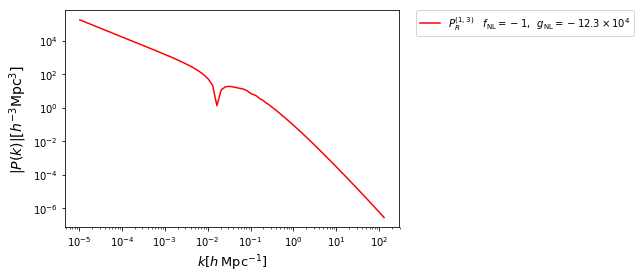

In [8]:
#Plot of P_R^(1,3) term


k13r,pk13r=np.loadtxt('results/p13r-fnl-1gnl-12.dat',unpack=True)

fig=figure() 

xlabel('$k[h\:\\rm{Mpc}^{-1}]$',fontsize=13)
ylabel('$\\left|{P(k)}\\right|[h^{-3}\\rm{Mpc}^3]$',fontsize=14)

loglog(k13r,abs(pk13r), color='red', label='$P_R^{(1,3)}\quad f_{\\rm NL}=-1,\enspace g_{\\rm NL}=-12.3\\times10^4$',linestyle='solid')


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [9]:
#Calculation of P_R1 term


def xargument_rr1(x,q,k):
    r = q/k
    factorx =(3.*fnl*(1.+r**2+2.*r*x)+(5./6.)*(3.*r*x-6.+6.*r**2))/(q**2)
    xargument =factorx
    return xargument

def prr1_argument_rel(q,k):
    r = q/k
    x_bis_min = -1.
    x_bis_max = min(1.,1./(2.*r))
    xintegral = quad(xargument_rr1,x_bis_min,x_bis_max,args=(q,k))[0]
    return xintegral
    
def prr1_rel(k):
    aux0 = prr1_argument_rel(ktabla,k)
    prr1_arg = aux0*ptabla*ktabla**2
    prr1_integral = simps(prr1_arg,ktabla)
    #The factor of 2 comes from using those x's limits
    prr1 = 2.*(Hub**2/(4.*np.pi**2))*prr1_integral*linearpower(k)    
    return prr1





In [10]:
prr1_argument_rel = np.vectorize(prr1_argument_rel)

prr1r_tabla =list(map(prr1_rel,ktabla))

#Saving P_R1 in a .dat file
np.savetxt("results/pr1-fnl-"+str(fnl1)+".dat",np.transpose([ktabla,prr1r_tabla]))


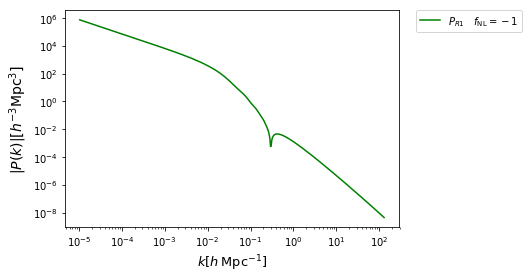

In [11]:
#Plot of P_R1 term

krr1, pkrr1=np.loadtxt('results/pr1-fnl-1.dat', unpack = True)

fig=figure() 
xlabel('$k[h\:\\rm{Mpc}^{-1}]$',fontsize=13)
ylabel('$\\left|{P(k)}\\right|[h^{-3}\\rm{Mpc}^3]$',fontsize=14)
 

loglog(krr1,abs(pkrr1), color='green', label='$P_{R1}\quad f_{\\rm NL}=-1$',linestyle='solid')


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [12]:
def xargument_rr2(x,q,k):
    r = q/k
    den = 1. + r**2 - 2.*r*x
    factorx =(6.*fnl-10.-25.*r**2+25.*r*x)/(4.*q**2*(den))
    xargument = linearpower(k*np.sqrt(den))*factorx
    return xargument

def prr2_argument_rel(q,k):
    r = q/k
    x_bis_min = -1.
    x_bis_max = min(1.,1./(2.*r))
    xintegral = quad(xargument_rr2,x_bis_min,x_bis_max,args=(q,k))[0]
    return xintegral
    
def prr2_rel(k):
    aux0 = prr2_argument_rel(ktabla,k)
    prr2_arg = aux0*ptabla*ktabla**2
    prr2_integral = simps(prr2_arg,ktabla)
    #The factor of 2 comes from using those x's limits
    prr2 = (2.*Hub**2/(4.*np.pi**2))*prr2_integral    
    return prr2


In [ ]:
prr2_argument_rel = np.vectorize(prr2_argument_rel)

prr2r_tabla =list(map(prr2_rel,ktabla))

#Saving P_R2 in a .dat file
np.savetxt("results/pr2-fnl-"+str(fnl1)+".dat",np.transpose([ktabla,prr2r_tabla]))


In [ ]:
#Plot of P_R2 term

krr2, pkrr2=np.loadtxt('results/pr2-fnl-1.dat', unpack = True)


fig=figure() 
xlabel('$k[h\:\\rm{Mpc}^{-1}]$',fontsize=13)
ylabel('$\\left|{P(k)}\\right|[h^{-3}\\rm{Mpc}^3]$',fontsize=14)
 
loglog(krr2,abs(pkrr2), color='magenta', label='$P_{R2}\quad f_{\\rm NL}=-1$',linestyle='solid')


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)